In [1]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn import cross_validation

# Preparing data

In [3]:
# read all the files names 
from glob import glob
from os import path

def get_files_in(folder, pattern='*.txt'):
    return glob(path.join(folder, pattern))

def filenames(folder):
    filename = get_files_in(folder, '*.jpg')
    filename1 = get_files_in(folder, '*.mat')
    for i in range(len(filename1)):
        filename.append(filename1[i])
    return filename


In [4]:
# for each image lable it as cat or dog
def image_lable(file_dir):
    image_dir = filenames(file_dir)
    lable = []
    img_name = []
    for i in range(len(image_dir)):
        image = cv2.imread(image_dir[i]) #read in BGR form
        if image == None: # ignore image that can not be read
            continue
        img_name.append(image_dir[i])
        if image_dir[i].split("/")[1][0].isupper() == True:
            lable.append(0) # 0 means cat
        else:
            lable.append(1) # 1 means dog
    return np.array(img_name), np.array(lable)

In [5]:
df_x,df_y = image_lable("images")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [6]:
df_x

array(['images/Abyssinian_1.jpg', 'images/Abyssinian_10.jpg',
       'images/Abyssinian_100.jpg', ..., 'images/yorkshire_terrier_97.jpg',
       'images/yorkshire_terrier_98.jpg', 'images/yorkshire_terrier_99.jpg'], 
      dtype='|S41')

In [10]:
X_train_name, X_test_name, Y_train, Y_test = cross_validation.train_test_split(df_x, df_y, test_size = 0.72, random_state = 10)

In [11]:
print X_train_name.shape, X_test_name.shape

(2067,) (5317,)


# Akaze Feature

In [12]:
from scipy.cluster.vq import *
from sklearn import preprocessing

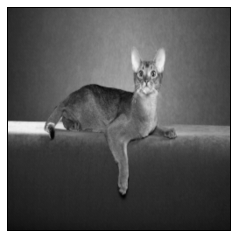

In [244]:
image = cv2.imread("images/Abyssinian_1.jpg",0) #read in BGR form
#image2 = image[:,:,::-1] # transfer it back to RGB same as cv2.cvtColor(img, cv2.BGR2RGB)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
res = cv2.resize(image,(256,256),interpolation = cv2.INTER_LINEAR)
plt.imshow(res, cmap = "gray", interpolation = "bicubic")
plt.xticks([]), plt.yticks([])
plt.show()

329 (329, 64)


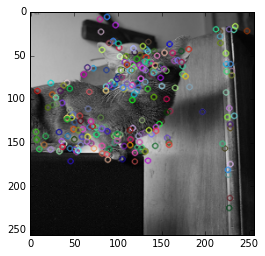

In [65]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(res,None)

img=cv2.drawKeypoints(res,kp,res)
plt.imshow(img)
print len(kp_surf), descs_surf.shape

329 (329, 64)


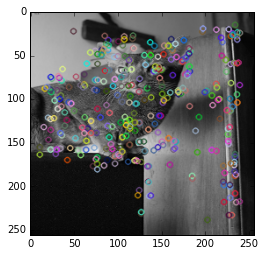

In [62]:
surf = cv2.xfeatures2d.SURF_create(100)
(kp_surf, descs_surf) = surf.detectAndCompute(res,None)

img_surf = cv2.drawKeypoints(res,kp_surf,res)
plt.imshow(img_surf)
print len(kp_surf), descs_surf.shape
#flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

keypoints: 163, descriptors: (163, 61)


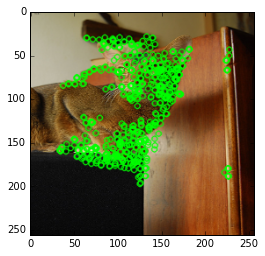

In [29]:
detector = cv2.AKAZE_create()
(kps, descs) = detector.detectAndCompute(res, None)
print("keypoints: {}, descriptors: {}".format(len(kps), descs.shape))

cv2.drawKeypoints(res, kps, res, (0,255,0))
plt.imshow(res)


ValueError: num must be 1 <= num <= 6, not 7

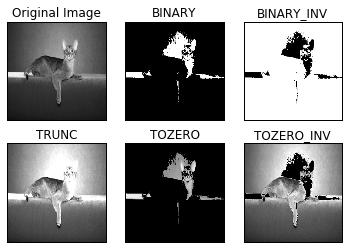

In [250]:
img = res
ret,thresh6 = cv2.threshold(res,127,255,0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

#contours,hierarchy = cv2.findContours(thresh, 1, 2)
#cnt = contours[0]
#x,y,w,h = cv2.boundingRect(cnt)
#cv2.rectangle(res,(x,y),(x+w,y+h),(0,255,0),2)

In [247]:
thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [234]:
def deskew(img):
    SZ = 200
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

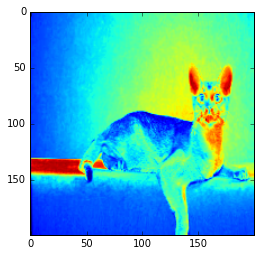

In [235]:
plt.imshow(deskew(res))

424


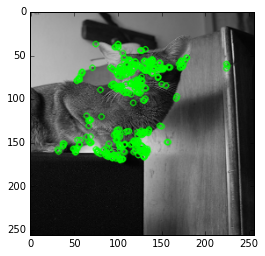

In [43]:
orb = cv2.ORB_create()
kp_orb= orb.detect(res, None)
#des_orb = orb.compute(res, kp_orb)

img_fast = cv2.drawKeypoints(res,kp_orb,res,(0,255,0))
plt.imshow(img_fast)
print len(kp_orb)#, descs_fast.shape



In [66]:
def SIFT_feature(img_list):
    sift = cv2.xfeatures2d.SIFT_create()
    des_list = []
    for i in range(len(img_list)):
        image = cv2.imread(img_list[i]) #read in BGR form
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # transfer to gray color
        res = cv2.resize(gray,(256,256),interpolation = cv2.INTER_LINEAR) #resize to 256*256
        (kp_sift, descs_sift) = sift.detectAndCompute(res,None)
        des_list.append(descs_sift)
    
    return des_list
    

In [67]:
def SURF_feature(img_list,threshold):
    surf = cv2.xfeatures2d.SURF_create(threshold)
    des_list = []
    for i in range(len(img_list)):
        image = cv2.imread(img_list[i],0) #read in gray form
        res = cv2.resize(image,(256,256),interpolation = cv2.INTER_LINEAR) #resize to 256*256
        (kp_surf, descs_surf) = surf.detectAndCompute(res,None)
        des_list.append(descs_surf)    
    return des_list


In [44]:
def AKAZE_feature(img_list):
    detector = cv2.AKAZE_create()
    des_list = []
    for i in range(len(img_list)):
        image = cv2.imread(img_list[i]) #read in BGR form
        image2 = image[:,:,::-1] # transfer it back to RGB same as cv2.cvtColor(img, cv2.BGR2RGB)
        res = cv2.resize(image2,(256,256),interpolation = cv2.INTER_LINEAR) #resize to 256*256
        (kp_akaze, descs_akaze) = detector.detectAndCompute(res,None)
        des_list.append(descs_akaze.astype(float, casting = 'same_kind'))   # normalize for faster convergent in kmeans
    return des_list

In [163]:
def k_mean(des_list, word_number):    
    descriptors = des_list[0]
    for descriptor in des_list[1:]:
        descriptors = np.vstack([descriptors.astype(float), descriptor])
    voc, variance = kmeans(descriptors, word_number, 1) 
    return voc, variancce

def BoW(des_list, word_number, voc):   
    im_features = np.zeros((len(des_list), word_number), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i],voc)
        for w in words:
            im_features[i][w] += 1
            
    # Perform Tf-Idf vectorization        
    #nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    #idf = np.array(np.log((1.0*len(des_list)+1) / (1.0*nbr_occurences + 1)), 'float32')
    
    # Perform L2 normalization
    #im_features = im_features*idf
    im_features = preprocessing.normalize(im_features, norm='l1')

    return im_features

In [68]:
sift_list_train = SIFT_feature(X_train_name)
sift_list_test = SIFT_feature(X_test_name)

In [69]:
descriptors = sift_list_train[0]
m = 1
for descriptor in sift_list_train[1:]:
    descriptors = np.vstack([descriptors, descriptor])
    m+=1
    print m

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [120]:
voc_sift

array([[  9.1112566 ,  12.1662302 ,  28.48429298, ...,  15.89397907,
         21.10602188,  28.01570702],
       [ 27.96168137,  36.92707062,  25.80964088, ...,  10.64400482,
          7.4276886 ,   9.51174259],
       [ 15.53188419,  20.85217476,  49.65652084, ...,  18.41884041,
         11.42608738,  13.25942039],
       ..., 
       [  8.63362026,   8.19109154,  16.97557449, ...,  52.02155304,
         33.75862122,  17.42097664],
       [ 66.66704559,  27.90045738,   9.90617847, ...,   6.30205965,
          6.32036591,  13.77002335],
       [ 11.96889591,  38.44168091,  70.62830353, ...,  22.58475876,
         26.29393387,  28.17729378]], dtype=float32)

In [81]:
voc_sift, lable_sift = kmeans2(descriptors, 1000, iter = 50) 

In [164]:
train_feature = BoW(sift_list_train, 1000, voc_sift)
test_feature = BoW(sift_list_test, 1000, voc_sift)

In [166]:
test_feature

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00124688,  0.        ,  0.00124688, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00288184,  0.00720461,  0.00144092, ...,  0.        ,
         0.00144092,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00384615],
       [ 0.        ,  0.        ,  0.00198807, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [ ]:
surf_list_train = SURF_feature(X_train_name,700)
surf_list_test = SURF_feature(X_test_name,700)

In [ ]:
descriptors = surf_list_train[0]
m = 1
for descriptor in surf_list_train[1:]:
    descriptors = np.vstack([descriptors, descriptor])
    m+=1
    print m
    
    

In [ ]:
voc, variance = kmeans(descriptors, 1000, 1) 

In [ ]:
train_feature = BoW(surf_list_train, 1000, voc)
test_feature = BoW(surf_list_test, 1000, voc)

In [46]:
akaze_list_train = AKAZE_feature(X_train_name)
akaze_list_test = AKAZE_feature(X_test_name)

In [47]:
descriptors1 = akaze_list_train[0]
m = 1
for descriptor in akaze_list_train[1:]:
    descriptors1 = np.vstack([descriptors1, descriptor])
    m+=1
    print m

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [88]:
descriptors1

array([[  32.,  118.,    7., ...,  255.,  255.,   39.],
       [  32.,   22.,    6., ...,  253.,  255.,   60.],
       [ 136.,    6.,   50., ...,  255.,   63.,    1.],
       ..., 
       [  33.,   76.,  111., ...,   67.,  248.,   62.],
       [  37.,   16.,  108., ...,  248.,  255.,   11.],
       [  33.,   93.,   79., ...,   65.,  200.,   62.]])

In [89]:
voc1, lable1 = kmeans2(descriptors1, 1000, iter = 50)

In [90]:
voc1

array([[ 202.01295337,  238.25647668,    6.09326425, ...,  203.83678756,
         158.95854922,   22.76943005],
       [  17.17846154,   23.47692308,   31.68      , ...,   97.35692308,
         176.43384615,   48.41230769],
       [  55.63692308,   17.18153846,  240.74461538, ...,  191.99076923,
         146.76615385,   36.27076923],
       ..., 
       [  52.84408602,  176.44623656,  148.70430108, ...,  189.19892473,
         152.7311828 ,   35.7688172 ],
       [ 125.13583815,   37.4017341 ,    7.02601156, ...,  217.28323699,
         229.44219653,   32.85260116],
       [  97.44370861,   30.58278146,  186.71192053, ...,  169.35761589,
         153.72516556,   17.50331126]])

In [91]:
train_feature = BoW(akaze_list_train, 1000, voc1)
test_feature = BoW(akaze_list_test, 1000, voc1)

In [54]:
test_feature

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  3.,  0., ...,  3.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  2.,  0.,  2.]], dtype=float32)

# HSV Feature

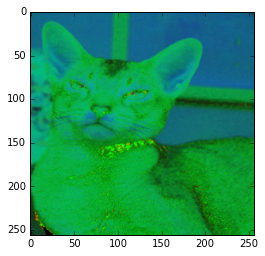

In [98]:
image = cv2.imread("images/Abyssinian_6.jpg") #read in BGR form
image2 = image[:,:,::-1] # transfer it back to RGB same as cv2.cvtColor(img, cv2.BGR2RGB)
gray = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)
res = cv2.resize(gray,(256,256),interpolation = cv2.INTER_LINEAR)
plt.imshow(res, cmap = "gray", interpolation = "bicubic")
#plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#input is image, number of intervals for Hue, Saturation, Value
#output is H*S*V vector
def HSV_histogram(image, Hue_Int, Sat_Int, Val_Int):
    Huerange = range(0,179,180/Hue_Int) # Hue is ranged from 0 to 179
    Satrange = range(0,255,256/Sat_Int)
    Valrange = range(0,255,256/Val_Int)
    
    r1 = image[:,:,0]
    r2 = image[:,:,1]
    r3 = image[:,:,2]
    
    H1, edge1 = np.histogram(r1, bins = Huerange)
    H1 = np.hstack([H1,r1.size-sum(H1)])
    H2, edge2 = np.histogram(r2, bins = Satrange)
    H2 = np.hstack([H2,r2.size-sum(H2)])
    H3, edge3 = np.histogram(r3, bins = Valrange)
    H3 = np.hstack([H3,r3.size-sum(H3)])
    
    freq = []
    for i in range(len(H1)):
        for j in range(len(H2)):
            for k in range(len(H3)):
                freq.append(float(H1[i]*H2[j]*H3[k])/float(r1.size * r2.size *r3.size))
    return np.array(freq)    

In [ ]:
def color_histogram(image, Red_Int, Green_Int, Blue_Int):
    Rrange = range(0,255,256/Red_Int)
    Grange = range(0,255,256/Green_Int)
    Brange = range(0,255,256/Blue_Int)
    r1 = image[:,:,0]
    r2 = image[:,:,1]
    r3 = image[:,:,2]
    
    H1, edge1 = np.histogram(r1, bins = Rrange)
    H1 = np.hstack([H1,r1.size-sum(H1)])
    H2, edge2 = np.histogram(r2, bins = Grange)
    H2 = np.hstack([H2,r2.size-sum(H2)])
    H3, edge3 = np.histogram(r3, bins = Brange)
    H3 = np.hstack([H3,r3.size-sum(H3)])
    
    freq = []
    for i in range(len(H1)):
        for j in range(len(H2)):
            for k in range(len(H3)):
                freq.append(float(H1[i]*H2[j]*H3[k])/float(r1.size * r2.size *r3.size))
    return np.array(freq)    

In [ ]:
# for each image take the feature to form matrix
def model_feature_HSV(img_list, Red, Green, Blue):
    feature = []
    for i in range(len(img_list)):
        image = cv2.imread(img_list[i]) #read in BGR form
        #image2 = image[:,:,::-1] # convert to RGB
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        res = cv2.resize(hsv,(256,256),interpolation = cv2.INTER_LINEAR) #resize to 256*256
        feature.append(HSV_histogram(res,Red,Green,Blue))
    return np.array(feature)

In [ ]:
# for each image take the feature to form matrix
def model_feature_RGB(img_list, Red, Green, Blue):
    feature = []
    for i in range(len(img_list)):
        image = cv2.imread(img_list[i]) #read in BGR form
        image2 = image[:,:,::-1] # convert to RGB
        res = cv2.resize(image2,(256,256),interpolation = cv2.INTER_LINEAR) #resize to 256*256
        feature.append(color_histogram(res,Red,Green,Blue))
    return np.array(feature)

In [ ]:
train_feature_HSV = model_feature_HSV(X_train_name, 6,8,8)
test_feature_HSV = model_feature_HSV(X_test_name, 6,8,8)

In [ ]:
train_feature_RGB = model_feature_RGB(X_train_name, 8,8,8)
#test_feature_RGB = model_feature_RGB(X_test_name, 8,8,8)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
sum(lable != lable_RGB)

In [ ]:
feature_HSV_SURF_train = np.hstack([train_feature_HSV, train_feature])
feature_HSV_SURF_test = np.hstack([test_feature_HSV, test_feature])

In [ ]:
feature_HSV_SURF_train.shape

In [148]:
train_feature

array([[ 0.,  0.,  0., ...,  0.,  0.,  2.],
       [ 0.,  4.,  3., ...,  0.,  3.,  3.],
       [ 0.,  1.,  0., ...,  1.,  1.,  0.],
       ..., 
       [ 1.,  2.,  0., ...,  1.,  0.,  3.],
       [ 1.,  3.,  1., ...,  1.,  4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32)

In [208]:
from sklearn import linear_model, metrics, datasets, tree, svm

In [210]:
svm = svm.LinearSVC(C = 3)
svm.fit(train_feature,Y_train)

LinearSVC(C=3, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [ ]:
svm = svm.LinearSVC

In [188]:
log = linear_model.LogisticRegressionCV(cv = 5, Cs = 6)
log.fit(train_feature,Y_train)

LogisticRegressionCV(Cs=6, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [211]:
print metrics.classification_report(Y_train, svm.predict(train_feature)) , metrics.classification_report(Y_train, log.predict(train_feature))

             precision    recall  f1-score   support

          0       0.94      0.04      0.09       667
          1       0.69      1.00      0.81      1400

avg / total       0.77      0.69      0.58      2067
             precision    recall  f1-score   support

          0       0.92      0.48      0.63       667
          1       0.80      0.98      0.88      1400

avg / total       0.84      0.82      0.80      2067



In [212]:
print metrics.classification_report(Y_test, svm.predict(test_feature)), metrics.classification_report(Y_test, log.predict(test_feature))

             precision    recall  f1-score   support

          0       0.86      0.02      0.05      1727
          1       0.68      1.00      0.81      3590

avg / total       0.74      0.68      0.56      5317
             precision    recall  f1-score   support

          0       0.67      0.27      0.38      1727
          1       0.73      0.94      0.82      3590

avg / total       0.71      0.72      0.68      5317



In [ ]:
from sklearn.externals import joblib
from scipy.cluster.vq import *